In [182]:
# Copyright 2015 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""A binary to train CIFAR-10 using a single GPU.

Accuracy:
cifar10_train.py achieves ~86% accuracy after 100K steps (256 epochs of
data) as judged by cifar10_eval.py.

Speed: With batch_size 128.

System        | Step Time (sec/batch)  |     Accuracy
------------------------------------------------------------------
1 Tesla K20m  | 0.35-0.60              | ~86% at 60K steps  (5 hours)
1 Tesla K40m  | 0.25-0.35              | ~86% at 100K steps (4 hours)

Usage:
Please see the tutorial and website for how to download the CIFAR-10
data set, compile the program and train the model.

http://tensorflow.org/tutorials/deep_cnn/
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import os.path
import time
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

#from cnn_utils import *
import tensorflow.python.platform
from tensorflow.python.platform import gfile
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
import resnet_model
import resnet_model_official
import cifar_input
import six
#from tensorflow.models.image.cifar10 import cifar10
# import cifar10


In [207]:
import tensorflow as tf
from tensorflow.data import Dataset, Iterator

dataset_train = Dataset.range(10)
dataset_val = Dataset.range(90, 100)

iter_train_handle = dataset_train.make_one_shot_iterator().string_handle()
iter_val_handle = dataset_val.make_one_shot_iterator().string_handle()
# iter_train_handle
print(type(iter_train_handle))
handle = tf.placeholder(tf.string, shape=[],name='dh')
iterator = Iterator.from_string_handle(
    handle, dataset_train.output_types, dataset_train.output_shapes)
next_batch = iterator.get_next()

with tf.train.MonitoredTrainingSession() as sess:
#     print(dir(sess))
    handle_train, handle_val = sess.run([iter_train_handle, iter_val_handle])
    print(type(handle_train),handle_train)

    for step in range(10):
        print('train', sess.run(next_batch, feed_dict={handle: handle_train}))

        if step % 3 == 0:
            print('val', sess.run(next_batch, feed_dict={handle: handle_val}))

<class 'tensorflow.python.framework.ops.Tensor'>
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
<class 'bytes'> b'\n,/job:localhost/replica:0/task:0/device:CPU:0\x12\tlocalhost\x1a\x16_16_OneShotIterator_12 \xee\xf1\x9a\xd0\xca\xb5\xdc\xe5\x04*(class tensorflow::data::IteratorResource'
train 0
val 90
train 1
train 2
train 3
val 91
train 4
train 5
train 6
val 92
train 7
train 8
train 9
val 93


In [205]:
handle = b'\n)/job:worker/replica:0/task:0/device:CPU:0\x12\x06worker\x1a\x12_0_OneShotIterator \x88\xca\x87\xfe\xca\xce\x8d\xf5:*%N10tensorflow4data16IteratorResourceE'
print(type(handle))
# print(type(str(handle,'utf-8')))
# print(tf.compat.as_str_any(handle))
handle_str = tf.constant(handle,dtype=tf.string)
print(handle_str.dtype)
print(handle_str.device)
print(dir(handle_str))
with tf.Session() as sess:
    print(sess.run(handle_str))
    print(type(sess.run(handle_str)))

<class 'bytes'>
<dtype: 'string'>

['OVERLOADABLE_OPERATORS', '__abs__', '__add__', '__and__', '__array_priority__', '__bool__', '__class__', '__copy__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__invert__', '__iter__', '__le__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmatmul__', '__rmod__', '__rmul__', '__ror__', '__rpow__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '__xor__', '_as_node_def_input', '_as_tf_output', '_c_api_shape', '_consumers', '_dtype', '_get_input_ops_without_shapes', '_id', '_op', '_override_operator', '_rank', '_shape', '_sha

In [2]:
train_dir=r'D:\wangfeicheng\Tensorflow\docker-multiple\ResNet\resnet50-cifar-ckpt-20190218\\'
os.path.dirname(train_dir)

'D:\\wangfeicheng\\Tensorflow\\docker-multiple\\ResNet\\resnet50-cifar-ckpt-20190218'

In [180]:
tf.reset_default_graph()
global_step = tf.train.create_global_step()
type(global_step)

tensorflow.python.ops.variables.RefVariable

In [181]:
with tf.Session() as sess:
#     init = tf.global_variables_initializer()
    
    sess.run(global_step.initializer)
    for i in range(10):
        global_step= global_step+1
        step = sess.run(global_step)
        print(step)

1
2
3
4
5
6
7
8
9
10


In [179]:
tf.reset_default_graph()
global_step = tf.get_variable('global_step',dtype=tf.int32,initializer=0)
print(global_step.shape)
with tf.Session() as sess:
    sess.run(global_step.initializer)
    for i in range(10):
        global_step= global_step+1
        step = sess.run(global_step)
        print(step)

()
1
2
3
4
5
6
7
8
9
10


In [3]:
FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('dataset', 'cifar10', 'cifar10 or cifar100.')
tf.app.flags.DEFINE_string('mode', 'eval', 'train or eval.')
# tf.app.flags.DEFINE_string('train_dir', 'cifar10_train/',
#                            """Directory where to write event logs """
#                            """and checkpoint.""")
# tf.app.flags.DEFINE_integer('max_steps', 20000,
#                             """Number of batches to run.""")
# tf.app.flags.DEFINE_boolean('log_device_placement', False,
#                             """Whether to log device placement.""")

In [4]:
import pickle
import os
eval_data_dir = r'D:\wangfeicheng\Tensorflow\cifar10-tensorflow\cifar-10-binary\cifar-10-batches-bin\test_batch.bin'
# Dimensions of the images in the CIFAR-10 dataset.
# See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
# input format.
'''
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. 
There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. 
The test batch contains exactly 1000 randomly-selected images from each class. 
The training batches contain the remaining images in random order, but some training batches may contain more images from one class 
than another. Between them, the training batches contain exactly 5000 images from each class. 
'''

label_bytes = 1  # 2 for CIFAR-100
height = 32
width = 32
depth = 3
TRAIN_NUM = 10000
image_bytes = height * width * depth+1
batch_bytes = TRAIN_NUM*image_bytes
# Every record consists of a label followed by the image, with a
# fixed number of bytes for each.
record_bytes = label_bytes + image_bytes


with open(eval_data_dir,'rb') as file:
    byte_stream = file.read(batch_bytes)
    data = np.frombuffer(byte_stream,dtype =np.uint8).reshape((TRAIN_NUM,image_bytes))
    print(data.shape)
    image = data[:,1:].reshape((TRAIN_NUM,depth,height,width)).transpose((0,2,3,1))
    label = data[:,0]
    
label_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
label_dict = {}
for key,value in enumerate(label_names):
#     print(key,value)
    label_dict[key] =value
# label_dict

(10000, 3073)


[  3 158 159 ... 124 129 110]
(10000, 32, 32, 3)
(10000,)
The image of 1 is 8:ship


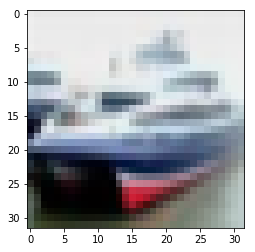

In [30]:
index = 1 
print(data[0,:])
print(image.shape)
print(label.shape)
plt.imshow(image[index])

print('The image of {0} is {1}:{2}'.format(index,label[index],label_dict[label[index]]))

In [53]:
image_ls = []
for index in range(0,100):
    image_pre = tf.image.per_image_standardization(image[index])
#     tf.append()
    image_ls.append(image_pre)
    image_tensor = tf.convert_to_tensor(image_ls)
    #print(type(image_pre)) 
with tf.Session() as sess:
    image_value = image_tensor.eval()
    print(image_value[:,:,:].shape)
#     print(np.mean(image_pre_np[:,:,:]))
#     print(np.std(image_pre_np))
#     print(image_pre_np)

(100, 32, 32, 3)


In [94]:
import pandas as pd
image_eval = image[0:100]
print(image_eval.shape)
# image_eval.std(axis=0).shape
# np.mean(image_eval,axis=0).shape
# np.apply_along_axis(np.mean,0,image_eval).shape
mean = image_eval.reshape((100,-1)).mean(axis=1)
std = image_eval.reshape((100,-1)).std(axis=1)
mean_exp = np.expand_dims(mean,axis=1)
(image_eval-mean_exp)

(100, 32, 32, 3)


ValueError: operands could not be broadcast together with shapes (100,32,32,3) (100,1) 

In [109]:
a = np.arange(24).reshape((2,3,4))
print(a)
mean = np.expand_dims(a.reshape((2,-1)).mean(axis=1),axis=1)
# print(a[0].mean())
a.reshape((2,-1))-mean

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]


array([[-5.5, -4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,
         5.5],
       [-5.5, -4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,
         5.5]])

In [112]:
M = np.ones((2, 3))
a = np.arange(3)
print(M,a)
M+a

[[1. 1. 1.]
 [1. 1. 1.]] [0 1 2]


array([[1., 2., 3.],
       [1., 2., 3.]])

In [111]:
a+M

array([[1., 2., 3.],
       [1., 2., 3.]])

In [29]:
np.eye(10)[label].shape

(10000, 10)

In [21]:
# Y_one_hot = tf.one_hot(label,10)
Y_test = tf.one_hot(label,10)

X_test = image

print(type(X_test),X_test.shape,X_test.dtype)
print(type(Y_test),Y_test.shape)
# X_test[index]

<class 'numpy.ndarray'> (10000, 32, 32, 3) uint8
<class 'tensorflow.python.framework.ops.Tensor'> (10000, 10)


In [7]:
#change the numpy ndarray into tensor
images_test = tf.cast(tf.convert_to_tensor(X_test),tf.float32)
labels_test = tf.cast(tf.convert_to_tensor(Y_test),tf.int32)

print(type(images_test),images_test.shape,images_test.dtype)
print(type(labels_test),labels_test.shape,labels_test.dtype)

<class 'tensorflow.python.framework.ops.Tensor'> (10000, 32, 32, 3) <dtype: 'float32'>
<class 'tensorflow.python.framework.ops.Tensor'> (10000, 10) <dtype: 'int32'>


In [10]:
# tf.InteractiveSession()
# pic=images_test.eval()
# print(type(pic),pic.shape,pic.dtype)
print(images_test.graph)

In [11]:
class ResNet(object):
    """ResNet model."""
    def __init__(self, hps, images, labels, mode):
        '''
        ResNet constructor.
        Args:
          hps: Hyperparameters.
          images: Batches of images. [batch_size, image_size, image_size, 3]
          labels: Batches of labels. [batch_size, num_classes]
          mode: One of 'train' and 'eval'.
        '''
        self.hps = hps
        self._images = images
        self.labels = labels
        self.mode = mode

        self._extra_train_ops = []

    def build_graph(self, istrain = True):
        """Build a whole graph for the model."""
        self.global_step = tf.train.get_or_create_global_step()
        self._build_model(istrain)
        if self.mode == 'train':
            self._build_train_op()
        self.summaries = tf.summary.merge_all()

    def _build_model(self, istrain):
        """Build the core model within the graph."""
        if dataset == 'cifar10':
            network = resnet_model_official.cifar10_resnet_v2_generator(resnet_size=50, num_classes = self.hps.num_classes, data_format=data_format)
        elif dataset == 'imagenet':
            network = resnet_model_official.imagenet_resnet_v2(resnet_size = 50, num_classes = self.hps.num_classes, data_format=data_format)
            
        
        logits = network(self._images, istrain)
        self.predictions = tf.nn.softmax(logits)
        cross_entropy = tf.losses.softmax_cross_entropy(
              logits=logits, onehot_labels=self.labels
        )
        tf.identity(cross_entropy, name='cross_entropy')
        tf.summary.scalar('cross_entropy', cross_entropy)

        # Add weight decay to the loss.
        self.cost = cross_entropy +self.hps.weight_decay_rate * tf.add_n(
          [tf.nn.l2_loss(v) for v in tf.trainable_variables()])

        tf.summary.scalar('cost', self.cost)

In [12]:
mode="eval"
dataset='cifar10'
num_classes = 10
data_format='channels_last'
batch_size = 10
hps = resnet_model.HParams(num_classes=num_classes,
                         lrn_rate=0.1,
                         weight_decay_rate=0.0002,
                         optimizer='mom')


images, labels = cifar_input.build_input(dataset, eval_data_dir, batch_size, mode)
model = ResNet(hps, images, labels, mode)
# model = ResNet(hps, images_test, labels_test, mode)
model.build_graph(istrain=False)


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.FixedLengthRecordDataset`.
Instructions for updating:
C

In [13]:
print(type(images),images.shape)
print(type(labels))
print(images.graph)

<class 'tensorflow.python.framework.ops.Tensor'> (10, 32, 32, 3)
<class 'tensorflow.python.framework.ops.Tensor'>


In [14]:
def create_config_proto():
    """Returns session config proto.
    Args:
    params: Params tuple, typically created by make_params or
            make_params_from_flags.
    """
    config = tf.ConfigProto()
    config.allow_soft_placement = True
    return config

In [144]:
import os
# train_dir='D:\\wangfeicheng\\Tensorflow\\docker-multiple\\ResNet\\resnet50-cifar-ckpt-20190218\\'
train_dir = r'D:\wangfeicheng\Tensorflow\docker-multiple\ResNet\resnet50-cifar-ckpt-20190218'
# print(type(train_dir))
# train_path = os.path.dirname(train_dir)
# print(type(train_path))
ckpt_state = tf.train.get_checkpoint_state(train_dir)
print(type(ckpt_state))
#dir(ckpt_state)
ckpt_state.model_checkpoint_path

<class 'str'>
<class 'str'>
<class 'tensorflow.python.training.checkpoint_state_pb2.CheckpointState'>


'/Tensorflow/docker-multiple/ResNet/resnet50-cifar-ckpt/model.ckpt-107738'

In [148]:
print('I am %s' %'michael')

I am michael


In [ ]:
train_dir=r'D:\wangfeicheng\Tensorflow\docker-multiple\ResNet\resnet50-cifar-ckpt-20190218\\'
eval_dir='D:\wangfeicheng\Tensorflow\docker-multiple\ResNet\resnet50-cifar-eval\\'
saver = tf.train.Saver()
# summary_writer = tf.summary.FileWriter(eval_dir)

sess = tf.Session(config=create_config_proto())
tf.train.start_queue_runners(sess)

best_precision = 0.0


try:
    ckpt_state = tf.train.get_checkpoint_state(train_dir)
except tf.errors.OutOfRangeError as e:
    tf.logging.error('Cannot restore checkpoint: %s', e)
if not (ckpt_state and ckpt_state.model_checkpoint_path):
    tf.logging.info('No model to eval yet at %s', train_dir)
tf.logging.info('Loading checkpoint %s', ckpt_state.model_checkpoint_path)
saver.restore(sess, ckpt_state.model_checkpoint_path)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Loading checkpoint /Tensorflow/docker-multiple/ResNet/resnet50-cifar-ckpt/model.ckpt-107738


In [15]:
print(model.cost.graph)

ERROR! Session/line number was not unique in database. History logging moved to new session 23


In [ ]:
eval_batch_count=10
for _ in six.moves.range(eval_batch_count):
    (summaries, loss, predictions, truth, train_step) = sess.run(
      [model.summaries, model.cost, model.predictions,model.labels, model.global_step])

    truth = np.argmax(truth, axis=1)
    predictions = np.argmax(predictions, axis=1)
    print('The truth:{}, and the prediction:{1}'.format(truth,predictions))

In [ ]:
# plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

# Calculate the correct predictions
predict_op = tf.argmax(Z3, 1)
correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

# Calculate accuracy on the test set
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print(accuracy)
train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

In [ ]:
def train():
  """Train CIFAR-10 for a number of steps."""
  with tf.Graph().as_default():
    global_step = tf.Variable(0, trainable=False)

    # Get images and labels for CIFAR-10.
    images, labels = cifar10.distorted_inputs()

    # Build a Graph that computes the logits predictions from the
    # inference model.
    logits = cifar10.inference(images)

    # Calculate loss.
    loss = cifar10.loss(logits, labels)

    # Build a Graph that trains the model with one batch of examples and
    # updates the model parameters.
    train_op = cifar10.train(loss, global_step)

    # Create a saver.
    saver = tf.train.Saver(tf.all_variables())

    # Build the summary operation based on the TF collection of Summaries.
    summary_op = tf.summary.merge_all()

    # Build an initialization operation to run below.
    init = tf.initialize_all_variables()

    # Start running operations on the Graph.
    sess = tf.Session(config=tf.ConfigProto(
        log_device_placement=FLAGS.log_device_placement))
    sess.run(init)

    # Start the queue runners.
    tf.train.start_queue_runners(sess=sess)

#     summary_writer = tf.train.SummaryWriter(FLAGS.train_dir,
#                                             graph_def=sess.graph_def)
    summary_writer = tf.summary.FileWriter(FLAGS.train_dir,graph_def=sess.graph_def)

    for step in xrange(FLAGS.max_steps):
      start_time = time.time()
      _, loss_value = sess.run([train_op, loss])
      duration = time.time() - start_time

      assert not np.isnan(loss_value), 'Model diverged with loss = NaN'

      if step % 10 == 0:
        num_examples_per_step = FLAGS.batch_size
        examples_per_sec = num_examples_per_step / duration
        sec_per_batch = float(duration)

        format_str = ('%s: step %d, loss = %.2f (%.1f examples/sec; %.3f '
                      'sec/batch)')
        print (format_str % (datetime.now(), step, loss_value,
                             examples_per_sec, sec_per_batch))

      if step % 100 == 0:
        summary_str = sess.run(summary_op)
        summary_writer.add_summary(summary_str, step)

      # Save the model checkpoint periodically.
      if step % 1000 == 0 or (step + 1) == FLAGS.max_steps:
        checkpoint_path = os.path.join(FLAGS.train_dir, 'model.ckpt')
        saver.save(sess, checkpoint_path, global_step=step)


def main(argv=None):  # pylint: disable=unused-argument
  cifar10.maybe_download_and_extract()
  if gfile.Exists(FLAGS.train_dir):
    gfile.DeleteRecursively(FLAGS.train_dir)
  gfile.MakeDirs(FLAGS.train_dir)
  train()


if __name__ == '__main__':
  tf.app.run()


In [ ]:
# x = tf.constant([[1], [2], [3], [4]], dtype=tf.float32)
x = tf.placeholder(dtype=tf.float32,shape = (1,None))

# y_true = tf.constant([[0], [-1], [-2], [-3]], dtype=tf.float32)
y_true = tf.placeholder(dtype=tf.float32,shape = (1,None))

linear_model = tf.layers.Dense(units=1)

y_pred = linear_model(X)
loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred)

optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
for batch_x,batch_y  in zip([[1], [2], [3], [4]],[[0], [-1], [-2], [-3]]):
  _ , loss_value = sess.run([train, loss],feed_dict = {x:batch_x,y_true:batch_y})
  print(loss_value)

print(sess.run(y_pred))